In [234]:
#!pip install nangs
#!pip install torchdiffeq

In [235]:
import numpy as np 
import scipy
import matplotlib.pyplot as plt 
import torch
import nangs
import math 
import sympy as sp

device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
#nangs.__version__, torch.__version__
torch.tensor([0., 0.]).to(device)

tensor([0., 0.])

In [236]:
# Build your own set of eigenfunctions
x,y = sp.symbols('x y', real=True)

f = sp.Matrix([y,-0.5*y - (x**2 - 1)*x])
F = f.jacobian([x,y])

# Linear and nonlinear parts of the dynamics at (0,0)
A = F.subs([(x,0),(y,0)]) 
fn = f - A*sp.Matrix([x,y]) 
E,W = np.linalg.eig(np.array(A.T).astype(np.float64)) 
w1 = W[:,0]; w2 = W[:,1]
l1 = E[0]; l2 = E[1]

# Relevant functions used for computation/comparision
g1 = np.dot(w1,fn)[0]; g2 = np.dot(w2,fn)[0] 
g1 = sp.lambdify((x,y),g1); g2 = sp.lambdify((x,y),g2)
f = sp.lambdify((x,y),tuple(f))

In [237]:
#Define the eigenfunction PDE
from nangs import PDE

lam = l1; # unstable eigenfunction
class Eigen(PDE):
    def computePDELoss(self, inputs, outputs):
                
        # compute gradients
        grads = self.computeGrads(outputs, inputs)
        
        # compute loss
        dpdx, dpdy = grads[:, 0], grads[:, 1]
        x, y = inputs[:, 0], inputs[:, 1]
        p = outputs
        u, v = f(x, y)
        g = g1(x,y)
        return {'pde': -lam*p + u*dpdx + v*dpdy + g}

# instantiate pde
pde = Eigen(inputs=('x', 'y'), outputs='p')

# Prepare training data

In [238]:
# define the sampler

from nangs import RandomSampler

sampler = RandomSampler({
    'x': [-0.45, 0.45], 
    'y': [-0.45, 0.45],
}, device=device, n_samples=2000)

pde.set_sampler(sampler)

In [239]:
sampler.sample(5)

{'x': tensor([-0.1457, -0.2711, -0.3336, -0.2879,  0.4449]),
 'y': tensor([-0.1650, -0.0923, -0.0370, -0.0924,  0.3801])}

Test stacking

In [240]:
# test stacking
# x0 = torch.tensor([[0],[0]], dtype=double).cuda()
# t = torch.tensor([0]).cuda()
# torch.vstack((f(t,x0), torch.exp(-eig1_real*t)*g_real(t,x0,w1_real)))

Test odeint

In [241]:
# test ode int
# from torchdiffeq import odeint
# H = lambda t,X : torch.vstack((f(t,torch.vstack((x0[0],x0[1]))), torch.exp(-eig1_real*t)*g_real(t,torch.vstack((x0[0],x0[1])),w1_real)))
# t_boundary = torch.tensor([0.]).cuda()

# sol = odeint(H, torch.vstack((x0[0],x0[1], torch.zeros(1).cuda())), t_boundary)
# sol[-1,2]

Test Initial conditions

In [242]:
# from torchdiffeq import odeint
# from nangs import Dirichlet

# H = lambda t,X : torch.vstack((f(t,torch.vstack((x0[0],x0[1]))), torch.exp(-eig1_real*t)*g_real(t,torch.vstack((x0[0],x0[1])),w1_real)))
# t_boundary = torch.tensor([0.,2.]).cuda()

# initial_condition1 = Dirichlet(
#     RandomSampler({'x': [-0.45, 0.45], 'y': 0.45}, device=device, n_samples=100), 
#     lambda inputs: {'p' : odeint(H, torch.vstack((inputs['x'].reshape(-1,1), inputs['y'].reshape(-1,1), torch.zeros(1).cuda())), t_boundary)[-1,2]},
#     name="test"
# )

# pde.add_boco(initial_condition1)

In [243]:
# from torchdiffeq import odeint
# from nangs import Dirichlet

# H = lambda t,X : torch.vstack((f(t,torch.vstack((x0[0],x0[1]))), torch.exp(-eig1_real*t)*g_real(t,torch.vstack((x0[0],x0[1])),w1_real)))
# t_boundary = torch.tensor([0.,2.]).cuda()

# initial_condition1 = Dirichlet(
#     RandomSampler({'x': [-0.45, 0.45], 'y': 0.45}, device=device, n_samples=100), 
#     lambda inputs: {'p' : odeint(H, torch.vstack((inputs['x'].reshape(-1,1), inputs['y'].reshape(-1,1), torch.zeros(1).cuda())), t_boundary)[-1,2]},
#     name="edge1"
# )

# initial_condition2 = Dirichlet(
#     RandomSampler({'x': [-0.45, 0.45], 'y': -0.45}, device=device, n_samples=100), 
#     lambda inputs: {'p' : odeint(H, torch.vstack((inputs['x'].reshape(-1,1), inputs['y'].reshape(-1,1), torch.zeros(1).cuda())), t_boundary)[-1,2]},
#     name="edge2"
# )

# initial_condition3 = Dirichlet(
#     RandomSampler({'x': 0.45, 'y': [-0.45, 0.45]}, device=device, n_samples=100), 
#     lambda inputs: {'p' : odeint(H, torch.vstack((inputs['x'].reshape(-1,1), inputs['y'].reshape(-1,1), torch.zeros(1).cuda())), t_boundary)[-1,2]},
#     name="edge3"
# )

# initial_condition4 = Dirichlet(
#     RandomSampler({'x': -0.45, 'y': [-0.45, 0.45]}, device=device, n_samples=100), 
#     lambda inputs: {'p' : odeint(H, torch.vstack((inputs['x'].reshape(-1,1), inputs['y'].reshape(-1,1), torch.zeros(1).cuda())), t_boundary)[-1,2]},
#     name="edge4"
# )

# pde.add_boco(initial_condition1)
# pde.add_boco(initial_condition2)
# pde.add_boco(initial_condition3)
# pde.add_boco(initial_condition4)

In [244]:
# initial_condition1.sample(7)

In [245]:
from torchdiffeq import odeint
from nangs import Dirichlet

H = lambda t,X : torch.vstack(f(X[0],X[1]) + (np.exp(-l1*t)*g1(X[0],X[1]),))
bounds = 2
initial_condition1 = Dirichlet(
    RandomSampler({'x': [-bounds, bounds], 'y': bounds}, device=device, n_samples=100), 
    lambda inputs: {'p' : odeint(H, torch.hstack((inputs['x'].reshape(-1,1), inputs['y'].reshape(-1,1), torch.zeros(len(inputs['x']),1))).T, torch.tensor([0.,5.]))[-1,2]},
    name="edge1"
)

initial_condition2 = Dirichlet(
    RandomSampler({'x': [-bounds, bounds], 'y': -bounds}, device=device, n_samples=100), 
    lambda inputs: {'p' : odeint(H, torch.hstack((inputs['x'].reshape(-1,1), inputs['y'].reshape(-1,1), torch.zeros(len(inputs['x']),1))).T, torch.tensor([0.,5.]))[-1,2]},
    name="edge2"
)

initial_condition3 = Dirichlet(
    RandomSampler({'x': bounds, 'y': [-bounds, bounds]}, device=device, n_samples=100), 
    lambda inputs: {'p' : odeint(H, torch.hstack((inputs['x'].reshape(-1,1), inputs['y'].reshape(-1,1), torch.zeros(len(inputs['x']),1))).T, torch.tensor([0.,5.]))[-1,2]},
    name="edge3"
)

initial_condition4 = Dirichlet(
    RandomSampler({'x': -bounds, 'y': [-bounds, bounds]}, device=device, n_samples=100), 
    lambda inputs: {'p' : odeint(H, torch.hstack((inputs['x'].reshape(-1,1), inputs['y'].reshape(-1,1), torch.zeros(len(inputs['x']),1))).T, torch.tensor([0.,5.]))[-1,2]},
    name="edge4"
)

pde.add_boco(initial_condition1)
pde.add_boco(initial_condition2)
pde.add_boco(initial_condition3)
pde.add_boco(initial_condition4)

In [246]:
initial_condition1.sample(3)

({'x': tensor([ 0.9605,  1.5743, -0.7978]), 'y': tensor([2., 2., 2.])},
 {'p': tensor([-2.0108, -2.4807, -0.5908])})

# Train

In [247]:
import torch.nn as nn

class Sine(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

class Tanh(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.tanh(x)
        

mlp = nn.Sequential(
	nn.Linear(2, 100),
	Tanh(), 
	nn.Linear(100, 100), 
	Tanh(), 
	nn.Linear(100, 1)
)

In [248]:
# solve

from nangs import MLP

LR = 1e-2
N_STEPS = 100000
NUM_LAYERS = 6
NUM_HIDDEN = 128

#mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, div_factor=10, final_div_factor=1, total_steps=N_STEPS)


In [249]:
mlp

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): Tanh()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): Tanh()
  (4): Linear(in_features=100, out_features=1, bias=True)
)

In [250]:
pde.compile(mlp, optimizer, scheduler)
%time hist = pde.solve(N_STEPS)

{'pde': 3e-05, 'edge1': 0.0, 'edge2': 0.0, 'edge3': 0.0, 'edge4': 0.0}: 100%|██████████| 100000/100000 [10:58:09<00:00,  2.53it/s]                  

Wall time: 10h 58min 9s


<AxesSubplot:>

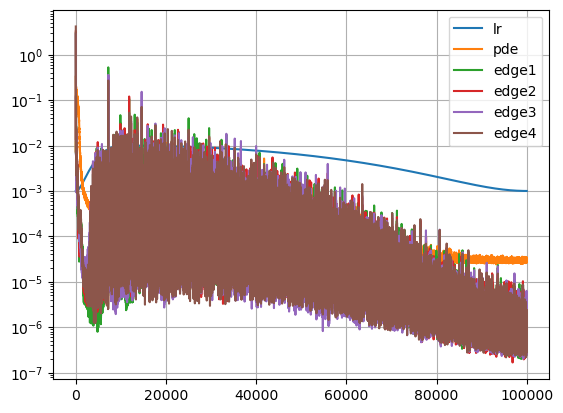

In [251]:
# plot loss history
import pandas as pd 

df = pd.DataFrame(hist)
fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
ax.set_yscale('log')
df.plot(ax=ax, grid=True)

#**Evaluate**

In [252]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

x = np.linspace(-2,2,100)
y = np.linspace(-2,2,100)

_x, _y = np.meshgrid(x, y)

grid = np.stack(np.meshgrid(x, y), -1).reshape(-1, 2)
X = torch.from_numpy(grid).float().to(device)
p = pde.eval(X)
p = p.cpu().numpy()

In [253]:
X.requires_grad_(True)
p = mlp(X)
grads = pde.computeGrads(p,X)
dpdx, dpdy = grads[:, 0].detach().numpy().reshape((len(_y),len(_x))), grads[:, 1].detach().numpy().reshape((len(_y),len(_x)))
p = p.detach().numpy().reshape((len(_y),len(_x)))
u,v = f(_x,_y)
g = g1(_x,_y)
error = -lam*p + u*dpdx.reshape((len(_y),len(_x))) + v*dpdy.reshape((len(_y),len(_x))) + g

# Visualize

In [254]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np

"""
# Matplotlib not pretty 
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(_x, _y, p + w1[0]*_x + w1[1]*_y, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.plot_surface(_x, _y, -(w1[0]/2)*p2(_x,_y), cmap=cm.spring, linewidth=0, antialiased=False)
plt.show()
"""

layout = go.Layout(
    title = 'Overview',
    xaxis = go.layout.XAxis(
        title = 'x',
        showticklabels=False),
    yaxis = go.layout.YAxis(
        title = 'y',
        showticklabels=False
    )
)

fig = go.Figure(data=[go.Heatmap(z=p, x=x, y=y, colorscale='jet')], layout=layout)

fig.update_layout(title='Unstable Eigenfunction for Duffing Oscillator', autosize=False,
                  width=600, height=500,
                  margin=dict(l=15, r=20, b=15, t=30))

# fig.update_layout(scene_aspectmode='cube')
fig.show()


In [255]:
# Save if all looks A-OK !
# from google.colab import files
# torch.save(mlp.state_dict(),'checkpoint.pth')
# files.download('checkpoint.pth')